In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np
import math
from pathlib import Path

In this Notebook we treat single sensor data for the setup1. We find the calibration coefficient W/V. We graphicate Laser power-Mean optical power, Laser power-Mean reference PD and Mean reference PD-Mean optical power. We also characterize the effect of temperature to the first two graphs.

In [2]:
def GetNumberOfFiles(wavelength,folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if wavelength in filename:
            count += 1
    print(f"Number of files in the folder with {wavelength} in their name: {count}")
    return count


In [3]:
def temp_distr_1(folder_path, wavelength):
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Temperature=[]

    for i in range(1, nfile+1):
        #filename = f'{folder_path}/calibration_24072024_PD_{wavelength}_{i}.txt'
        #filename = f'{folder_path}/temperatura_22_26072024_PD_{wavelength}_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['date-time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        T['date']=pd.to_datetime(T['date-time']).dt.date
        T['time']=pd.to_datetime(T['date-time']).dt.time
        T.drop('date-time',axis=1)
        T = T[['date', 'time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']]
        
        Temp=T['Temp'].tolist()

#Fem una llista amb tots les temperatures de tots els sets.
        for k in range(len(Temp)):
            Temperature.append(Temp[k])
        

    # Create a dictionary to count the occurrences
    frequency_dict = {}
    for number in Temperature:
        if number in frequency_dict:
            frequency_dict[number] += 1 #l'hi suma 1 si ja hi apareix
        else:
            frequency_dict[number] = 1 #sino en posa 1



    # Extract keys (numbers) and values (frequencies) from the dictionary
    Temperature = list(frequency_dict.keys())
    frequencies = list(frequency_dict.values())

    print(Temperature)
    print(frequencies)

    # Plotting the bar chart
    plt.bar(Temperature, frequencies, 0.09)
    plt.xlabel('Temperature ºC')
    plt.title(f'Frequency of Temperatures for the {wavelength} nm wavelength')
    #plt.xlim(19,22)
    plt.show()    
        

In [4]:
def temp_distr_2(folder_path, wavelength):
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Temperature=[]

    if wavelength == '532':
        # Rename DataFrame columns
        strg_L = 'Laser Current (mA)'
        temp = '20'
    elif wavelength == '1064':
        strg_L = 'Laser Power (mW)'
        temp = '25'

    for i in range(1, nfile+1):
        filename = f'{folder_path}/Laser_{wavelength}_Step_50_Temp_{temp}_PM_MM_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['date','time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        Temp=T['Temp'].tolist()

#Fem una llista amb tots les temperatures de tots els sets.
        for k in range(len(Temp)):
            Temperature.append(Temp[k])
        

    # Create a dictionary to count the occurrences
    frequency_dict = {}
    for number in Temperature:
        if number in frequency_dict:
            frequency_dict[number] += 1 #l'hi suma 1 si ja hi apareix
        else:
            frequency_dict[number] = 1 #sino en posa 1



    # Extract keys (numbers) and values (frequencies) from the dictionary
    Temperature = list(frequency_dict.keys())
    frequencies = list(frequency_dict.values())

    print(Temperature)
    print(frequencies)

    # Plotting the bar chart
    plt.bar(Temperature, frequencies, 0.09)
    plt.xlabel('Temperature ºC')
    plt.title(f'Frequency of Temperatures for the {wavelength} nm wavelength')
    #plt.xlim(20,24)
    plt.show()    
        

In [5]:
#temp_distr_1('./Useful_data/setup1/Calibration_july_2024/data/1064nm','1064')
#temp_distr_1('./Useful_data/setup1/Calibration_july_2024/data/532nm','532')
#temp_distr_2('./Useful_data/setup1/Calibration_december_2023/data/1064nm','1064')
#temp_distr_2('./Useful_data/setup1/Calibration_december_2023/data/532nm','532')
#temp_distr_1('./Useful_data/setup1/Temperatura_22_2024/data/532nm','532')
#temp_distr_1('./Useful_data/setup1/Temperatura_22_2024/data/1064nm','1064')

In [6]:
def Sensor_setup1(folder_path,txtname,wavelength):   
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Tfull= pd.DataFrame()
    Tpedestalfull= pd.DataFrame()
    foldername=os.path.basename(os.path.dirname(os.path.dirname(folder_path)))
    outputpath =  f'./Plots/setup1/{foldername}/{wavelength}nm'
    print(foldername)

#./Useful_data/setup1/Calibration_december_2023/data/1064nm
    # Define the variable pairs
    pairs = [
        ('meanRefPD', 'meanPM', 'slopes1', 'intercepts1', 'rCoes1', 'stderr1', 'intercepts_stderr1'),
        ('L', 'meanPM', 'slopes2', 'intercepts2', 'rCoes2', 'stderr2', 'intercepts_stderr2'),
        ('L', 'meanRefPD', 'slopes3', 'intercepts3', 'rCoes3', 'stderr3', 'intercepts_stderr3')
    ]

    # Initialize lists
    slopes,slopes1, slopes2, slopes3= [], [], [], []
    intercepts, intercepts1, intercepts2, intercepts3= [], [], [], []
    rCoes, rCoes1, rCoes2, rCoes3= [], [], [], []
    stderr, stderr1, stderr2, stderr3= [], [], [], []
    intercepts_stderr, intercepts_stderr1, intercepts_stderr2, intercepts_stderr3 = [], [], [], []
    #We generate a vector where we will save the mean temperature for each folder
    Tm=[]

    if not os.path.exists(outputpath):
        os.makedirs(outputpath)
        print(f"Directory '{outputpath}' created.")
    else:
        print(f"Directory '{outputpath}' already exists.")

    if wavelength == '532':
        # Rename DataFrame columns
        strg_L = 'Laser Current (mA)'
        temp = '20'
    elif wavelength == '1064':
        strg_L = 'Laser Power (mW)'
        temp = '25'

    for i in range(1, nfile+1):
        #Pels files que tenen la data i l'hora en columnes separades

        #if folder_path == './Useful_data/setup1/Calibration_april_2024/data/1064nm' or folder_path == './Useful_data/setup1/Calibration_april_2024/data/532nm' or  folder_path == './Useful_data/setup1/Calibration_december_2023/data/1064nm' or folder_path == './Useful_data/setup1/Calibration_december_2023/data/532nm':
        #    filename1 = f'{folder_path}/Laser_{wavelength}_Step_50_Temp_{temp}_PM_MM_{i}.txt'
        #    T = pd.read_csv(filename1,delimiter ='\t',header=None)
        #    T.columns = ['date', 'time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']


        #Pels files que tenen la data i l'hora a la mateixa columna

        #if folder_path == './Useful_data/setup1/Calibration_july_2024/data/1064nm' or folder_path == './Useful_data/setup1/Calibration_july_2024/data/532nm' or folder_path== './Useful_data/setup1/prova_july_2024/data/532nm' or folder_path=='./Useful_data/setup1/prova_july_2024/data/1064nm' or folder_path=='./Useful_data/setup1/Temperatura_22_2024/data/1064nm' or folder_path=='./Useful_data/setup1/Temperatura_22_2024/data/532nm'or folder_path =='./Useful_data/setup1/Temperatura_24_2024/data/532nm'or'./Useful_data/setup1/Temperatura_24_2024/data/1064nm':
            #filename2 = f'{folder_path}/calibration_24072024_PD_{wavelength}_{i}.txt'
            #filename2=f'{folder_path}/prueba_24072024_PD_{wavelength}_{i}.txt'
            #filename2=f'{folder_path}/temperatura_22_26072024_PD_{wavelength}_{i}.txt'
        #    filename2=f'{folder_path}/temperatura_24_30072024_PD_{wavelength}_{i}.txt'
        #    T = pd.read_csv(filename2,delimiter ='\t',header=None)
        #    T.columns = ['date-time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        #    T['date']=pd.to_datetime(T['date-time']).dt.date
        #    T['time']=pd.to_datetime(T['date-time']).dt.time
        #    T.drop('date-time',axis=1)
        #    T = T[['date', 'time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']]


        filename=f'{folder_path}/{txtname}_{wavelength}_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['date-time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        T['date']=pd.to_datetime(T['date-time']).dt.date
        T['time']=pd.to_datetime(T['date-time']).dt.time
        T.drop('date-time',axis=1)
        T = T[['date', 'time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']]

        Temp_mitja=T['Temp'].mean()
        Tm.append(Temp_mitja)

        # Create a new DataFrame by copying the first row of the original DataFrame
        Tpedestal=T.head(1).copy()
        # Remove the first row from T that corresponds to the pedestal
        T = T.iloc[1:]
        
        # Now concatenate it to the previous pandas frame
        Tfull = pd.concat([Tfull, T])
        Tpedestalfull = pd.concat([Tpedestalfull, Tpedestal])

        # Perform the linear regressions
        for x_var, y_var, slope_name, intercept_name, rcoe_name, stderr_name, intercept_stderr_name in pairs:
            res = linregress(T[x_var], T[y_var])
            
            eval(f"{slope_name}.append(res.slope)")
            eval(f"{intercept_name}.append(res.intercept)")
            eval(f"{rcoe_name}.append(res.rvalue)")
            eval(f"{stderr_name}.append(res.stderr)")
            eval(f"{intercept_stderr_name}.append(res.intercept_stderr)")

        #This gives us lists for the slopes, intercepts, rvalues... of each sensor
        # Create separate figures for each plot
        fig = plt.figure(i)
        plt.errorbar(T['L'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel(strg_L)
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_{i}_L_PM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        fig = plt.figure(i + 1)
        plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel(strg_L)
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_{i}_L_PD.png',dpi=199)  # Display the current figure
        plt.close(fig)

        #Linear fit 
        res = linregress(T['meanRefPD'], T['meanPM'])
        slope = res.slope 
        intercept = res.intercept
        r=res.rvalue
        se = res.stderr
        intercept_stderr = res.intercept_stderr

        slopes.append(slope)
        intercepts.append(intercept)
        rCoes.append(r)
        stderr.append(se)
        intercepts_stderr.append(intercept_stderr)

        fig = plt.figure(i + 2)
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.plot(T['meanRefPD'], intercept + slope*T['meanRefPD'], 'r', label='fitted line')
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_{i}_PD_PM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        plt.figure(101)
        plt.grid()
        plt.errorbar(T['L'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel(strg_L)
        plt.title(f'all datasets')
        
        
        plt.figure(102)
        plt.grid()
        plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel(strg_L)
        plt.title(f'all datasets')
        

        plt.figure(103)
        plt.grid()
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.title(f'all datasets')


    #We find the linear regression of the temperature with the laser-PM slopes 
    resPDPM=linregress(Tm,slopes1)
    slopePDPM = resPDPM.slope 
    interceptPDPM = resPDPM.intercept
    rPDPM=resPDPM.rvalue
    sePDPM = resPDPM.stderr
    intercept_stderrPDPM = resPDPM.intercept_stderr
    equationPDPM = f"y = {slopePDPM:.8f}x + {interceptPDPM:.8f}"

    #Plot dels slopes per la PM en funció de la temperatura mitja de cada fitxer, no cal fer regressió lineal perque 
    #totes han de tenir el mateix valor.
    fig = plt.figure(104)
    plt.grid()
    plt.errorbar(Tm, slopes1, fmt='.', markersize=10, linewidth=1)
    plt.axhline(y=np.mean(slopes1), color='r', linestyle='-', label='mean slope value')
    plt.text(min(Tm), max(slopes1), f'mean slope value={np.mean(slopes1):.5f}', fontsize=12, color='red')
    plt.ylabel('Mean ref PD-Mean Optical Power slopes')
    plt.xlabel('Mean temperature (Cº)')
    plt.title('PD-PM slopes')
    plt.savefig(f'{outputpath}/Slopes_{wavelength}_Step_50_PDPM.png',dpi=199)  # Display the current figure
    plt.close(fig)

    #Plot dels slopes per la PM en funció del temps d'inici de cada fitxer, no cal fer regressió lineal perque 
    #totes han de tenir el mateix valor.
    fig=plt.figure(114)
    plt.grid()
    plt.errorbar(range(len(slopes1)), slopes1, fmt='.', markersize=10, linewidth=1)
    #plt.axhline(y=meanwog, color='r', linestyle='-', label='mean ADC/V') per posar la mitja dsps
    plt.ylabel('Mean ref PD-Mean Optical Power slopes')
    plt.xlabel('Test timeline')
    plt.xticks(ticks=range(len(Tpedestalfull['time'])), labels=Tpedestalfull['time'])
    plt.tick_params(axis='x', labelsize=7)
    plt.title('PD-PM slopes')
    plt.savefig(f'{outputpath}/Slopes_{wavelength}_Step_50_PDPM_time.png',dpi=199)  # Display the current figure
    plt.close(fig)


    #Mirem si la linealitat es veu alterada per la temperatura, representem R pel grafic PDPM en funció de la temperatura
    equationcoes=f"y = {linregress(Tm,rCoes1).slope:.6f}x + {linregress(Tm,rCoes1).intercept:.3f}"
    fig = plt.figure(105)
    plt.grid()
    plt.errorbar(Tm, rCoes1, fmt='.', markersize=10, linewidth=1)
    plt.plot(Tm, linregress(Tm,rCoes1).intercept + linregress(Tm,rCoes1).slope*np.array(Tm), 'r', label='fitted line')
    plt.text(min(Tm), min(rCoes1), equationcoes, fontsize=12, color='red')
    plt.text(max(Tm),min(rCoes1),f'R={linregress(Tm,rCoes1).rvalue}')
    plt.ylabel('Mean ref PD-Mean Optical Power R values')
    plt.xlabel('Mean temperature (Cº)')
    plt.title('PD-PM R values')
    plt.savefig(f'{outputpath}/R_{wavelength}_Step_50_PDPM.png',dpi=199)  # Display the current figure
    plt.close(fig)
    #No veig dependència amb la temperatura per tant no calculo res més.

    
    #We find the linear regression of the temperature with the laser-PM slopes 
    resPM = linregress(Tm,slopes2)
    slopePM = resPM.slope 
    interceptPM = resPM.intercept
    rPM=resPM.rvalue
    sePM = resPM.stderr
    intercept_stderrPM = resPM.intercept_stderr
    equationPM = f"y = {slopePM:.8f}x + {interceptPM:.8f}"

    #Plot dels slopes per la PM en funció de la temperatura mitja de cada fitxer
    fig = plt.figure(106)
    plt.grid()
    plt.errorbar(Tm, slopes2, fmt='.', markersize=10, linewidth=1)
    plt.plot(Tm, interceptPM + slopePM*np.array(Tm), 'r', label='fitted line')
    plt.text(min(Tm), min(slopes2), equationPM, fontsize=12, color='red')
    plt.ylabel('Mean Optical Power-Laser Power slopes')
    plt.xlabel('Mean temperature (Cº)')
    plt.title('PM slopes')
    plt.savefig(f'{outputpath}/Slopes_{wavelength}_Step_50_PM.png',dpi=199)  # Display the current figure
    plt.close(fig)

    #We find the linear regression of the temperature with the laser-PD slopes 
    resRPD = linregress(Tm,slopes3)
    slopeRPD = resRPD.slope 
    interceptRPD = resRPD.intercept
    rRPD=resRPD.rvalue
    seRPD = resRPD.stderr
    intercept_stderrRPD = resRPD.intercept_stderr
    equationRPD = f"y = {slopeRPD:.8f}x + {interceptRPD:.8f}"


    #Plot dels slopes per la PD en funció de la temperatura mitja de cada fitxer
    fig=plt.figure(107)
    plt.grid()
    plt.errorbar(Tm, slopes3, fmt='.', markersize=10, linewidth=1)
    plt.plot(Tm, interceptRPD + slopeRPD*np.array(Tm), 'r', label='fitted line')
    # Annotate the equation on the graph
    plt.text(min(Tm), min(slopes3), equationRPD, fontsize=12, color='red')
    plt.ylabel('Mean ref PD - Laser Power slopes')
    plt.xlabel('Mean temperature (Cº)')
    plt.title('Ref PD slopes')
    plt.savefig(f'{outputpath}/Slopes_{wavelength}_Step_50_RefPD.png',dpi=199)  # Display the current figure
    plt.close(fig)


    SignalAnalysis(Tfull,nfile,slopes,stderr,intercepts,intercepts_stderr,rCoes,res,outputpath,wavelength)
    PedestalAnalysis(Tpedestalfull['meanRefPD'],Tpedestalfull['stdRefPD'],'Optical Power (W)',outputpath, wavelength)
    PedestalAnalysis(Tpedestalfull['meanPM'],Tpedestalfull['stdPM'],'ref PD (V)',outputpath, wavelength)

    return Tfull, Tpedestalfull
 

In [7]:
def temp_stable(folder_path, wavelength):
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Tfull= pd.DataFrame()
    Tpedestalfull= pd.DataFrame()
    foldername=os.path.basename(os.path.dirname(os.path.dirname(folder_path)))
    outputpath =  f'./Plots/setup1/{foldername}/{wavelength}nm'
    T1,T2,T3,T4,T5=[], [], [], [], []
    V1,V2,V3,V4,V5=[], [], [], [], []
    P1,P2,P3,P4,P5=[], [], [], [], []
    Temperature, Power, Voltage=[],[],[]

    for i in range(1, nfile+1):
        filename = f'{folder_path}/calibration_24072024_PD_{wavelength}_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['date-time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        T['date']=pd.to_datetime(T['date-time']).dt.date
        T['time']=pd.to_datetime(T['date-time']).dt.time
        T.drop('date-time',axis=1)
        T = T[['date', 'time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']]
        
        Temp=T['Temp'].tolist()
        Pow=T['meanPM'].tolist()
        Volt=T['meanRefPD'].tolist()

#Fem una llista amb tots les temperatures, potencies i voltatges de tots els sets.
        for k in range(len(Temp)):
            Temperature.append(Temp[k])
            Power.append(Pow[k])
            Voltage.append(Volt[k])

    print(Temperature)
    for j in range(len(Temperature)):
        if Temperature[j] < 19.7:
            T1.append(Temperature[j])
            V1.append(Voltage[j])
            P1.append(Power[j])

        if Temperature[j] < 19.9 and Temperature[j] > 19.7:
            T2.append(Temperature[j])
            V2.append(Voltage[j])
            P2.append(Power[j])

        if Temperature[j] < 20.1 and  Temperature[j] > 19.9:
            T3.append(Temperature[j])
            V3.append(Voltage[j])
            P3.append(Power[j])

        if Temperature[j] < 20.3 and Temperature[j] > 20.1:
            T4.append(Temperature[j])
            V4.append(Voltage[j])
            P4.append(Power[j])

        if Temperature[j] >20.3:
            T5.append(Temperature[j])
            V5.append(Voltage[j])
            P5.append(Power[j])

    print(Temperature[j])
    print(T1)
    print(V1)
    print(P1)
    
    #We find the linear regression of the temperature with the laser-PM slopes 
    res1=linregress(V1,P1)
    res2=linregress(V2,P2)
    res3=linregress(V3,P3)
    res4=linregress(V4,P4)
    res5=linregress(V5,P5)

    Slopes=[res1.slope,res2.slope,res3.slope,res4.slope,res5.slope]
    Intercepts=[res1.intercept,res2.intercept,res3.intercept,res4.intercpet,res5.intercept]
    Ts=[19.6,19.8,20,20.2,20.4]


    #Plot de slopes vs temperature
    plt.figure(1000)
    plt.grid()
    plt.errorbar(Ts, Slopes, fmt='.', markersize=10, linewidth=1)
    #plt.axhline(y=np.mean(slopes1), color='r', linestyle='-', label='mean slope value')
    #plt.text(min(Tm), min(slopes1), f'mean slope value={np.mean(slopes1):.5f}', fontsize=12, color='red')
    plt.ylabel('Slopes PD-PM vs temperature')
    plt.xlabel('Temperature (Cº)')
    plt.title('PD-PM slopes')
    plt.savefig(f'{outputpath}/Slopes_{wavelength}_PDPM.png',dpi=199)  # Display the current figure


    #Plot de intercpets vs temperature, HAURIA DE CANVIAR
    plt.figure(1001)
    plt.grid()
    plt.errorbar(Ts, Intercepts, fmt='.', markersize=10, linewidth=1)
    #plt.axhline(y=np.mean(slopes1), color='r', linestyle='-', label='mean slope value')
    #plt.text(min(Tm), min(slopes1), f'mean slope value={np.mean(slopes1):.5f}', fontsize=12, color='red')
    plt.ylabel('Intercepts PD-PM vs temperature')
    plt.xlabel('Mean temperature (Cº)')
    plt.title('PD-PM intecepts')
    plt.savefig(f'{outputpath}/Intercepts_{wavelength}_PDPM.png',dpi=199)  # Display the current figure

In [ ]:
def SignalAnalysis(Tfull,nfile,slopes,stderr,intercepts,intercepts_stderr,rCoes,res,outputpath,wavelength):  
     
    x=Tfull['meanRefPD']
    y=Tfull['meanPM']
    

    res = linregress(x, y)
    datasets= nfile
    slopes_micro=[i * 1e6 for i in slopes]
    stderr_micro=[i * 1e6 for i in stderr]
    

    intercepts_micro=[i * 1e6 for i in intercepts]
    intercepts_stderr_micro=[i * 1e6 for i in intercepts_stderr]

    print(f'Calibration coefficient found as linear adjustment of all the dataset = {res.slope*1e6} +/- {res.stderr*1e6} in $\mu$W/V')

    print(f'Calibration coefficient found as mean of the linear adjustment of each dataset = {np.mean(slopes_micro)} +/- {np.std(slopes_micro)} in $\mu$W/V')
   
    #Errors in percentage 
    relativeError = (np.mean(slopes)-res.slope)/np.mean(slopes)*100
    dispersion = (np.max(slopes)-np.min(slopes))/np.max(slopes)*100
    print('relativeError = ',relativeError,'% and dispersion = ',dispersion,'%')
    
    # Customize the plot
    fig = plt.figure(100)
    plt.errorbar(range(len(slopes)), slopes_micro,stderr_micro, fmt='.', markersize=10, linewidth=1)
    plt.title(f'{wavelength} nm, relative error = {relativeError:.2e}, dispersion = {dispersion:.2f}%')
    plt.xlabel('Dataset Index')
    plt.ylabel('Calibration coefficient ($\mu$W/V)')
    plt.xticks(range(datasets), [f'D {i+1}' for i in range(nfile)])  # Label the x-axis with dataset identifiers
    #plt.legend()
    plt.axhline(y=res.slope*1e6, color='red', linestyle='--', label='Horizontal Line at y=m_all')
    plt.axhline(y=np.mean(slopes_micro), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr)*1e6, (res.slope+res.stderr)*1e6, color='red', alpha=0.3, label='Shaded Region')
    plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes_micro)-np.std(slopes_micro)), (np.mean(slopes_micro)+np.std(slopes_micro)), color='purple', alpha=0.2, label='Shaded Region')
    #plt.ylim([0.00064*1e6, 0.000665*1e6])
    plt.xlim([-1,nfile])
    plt.grid()
    # Show the plot
    #plt.show()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_GAll_Cal_coeff.png',dpi=199)

    # Customize the plot
    fig = plt.figure(104)
    plt.errorbar(range(len(intercepts)), intercepts_micro,intercepts_stderr_micro, fmt='.', markersize=10, linewidth=1)
    plt.title(f'Offset for Different Datasets at {wavelength}')
    plt.xlabel('Dataset Index')
    plt.ylabel('Intercepts ($\mu$W)')
    plt.xticks(range(datasets), [f'D {i+1}' for i in range(nfile)])  # Label the x-axis with dataset identifiers
    #plt.legend()
    plt.axhline(y=res.intercept*1e6, color='red', linestyle='--', label='Horizontal Line at y=m_all')
    plt.axhline(y=np.mean(intercepts_micro), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(-1,len(intercepts)+1), (res.intercept-res.intercept_stderr)*1e6, (res.intercept+res.intercept_stderr)*1e6, color='red', alpha=0.3, label='Shaded Region')
    plt.fill_between(range(-1,len(intercepts)+1), (np.mean(intercepts_micro)-np.std(intercepts_micro)), (np.mean(intercepts_micro)+np.std(intercepts_micro)), color='purple', alpha=0.2, label='Shaded Region')
    #plt.ylim([0.00064*1e6, 0.000665*1e6])
    plt.xlim([-1,nfile])
    plt.grid()
    # Show the plot
    #plt.show()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_All_Intercepts.png',dpi=199)
    print('mean intercepts',res.intercept*1e6,'error', res.intercept_stderr*1e6)

    plt.figure(101)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_PM_MM_all_trend_LPower_PM.png',dpi=199)

    plt.figure(102)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_PM_MM_all_trend_LPower_PD.png',dpi=199)

    plt.figure(103)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_PM_MM_all_trend_PD_PM.png',dpi=199)

    return Tfull, slopes, intercepts, rCoes,stderr, res    

In [9]:
def PedestalAnalysis(mean, std, name, outputpath, wavelength):
    samples = len(mean)
    fig = plt.figure(1103)
    # Mean and std deviation of the PM 
    plt.errorbar(range(samples), mean, yerr=std, fmt='.', markersize=10, linewidth=1)
    plt.axhline(y=np.mean(mean), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(samples), np.mean(mean)-np.std(mean), np.mean(mean)+np.std(mean), color='red', alpha=0.3, label='Shaded Region')

    plt.ylabel(f'Pedestal of {name}')
    plt.xlabel('Test number [#]')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Pedestal_{wavelength}_{name}.png',dpi=199)  # Display the current figure
    plt.close(fig)
    print(f'The pedestal of the values',name,' are: Mean=',np.mean(mean),' std=',np.mean(std))

In [10]:
def PedestalTimeAnalysis(mean, std, time, name, outputpath, wavelength):
    samples = len(mean)
    fig=plt.figure(1103)
    # Mean and std deviation of the PM 
    plt.errorbar(range(samples), mean, yerr=std, fmt='.', markersize=10, linewidth=1)
    plt.ylabel(f'Pedestal of {name}')
    plt.xlabel('Test timeline')
    plt.xticks(ticks=range(len(time)), labels=time)
    plt.tick_params(axis='x', labelsize=7)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Pedestal_{wavelength}_{name}_time.png',dpi=199)  # Display the current figure
    plt.close(fig)
    print(f'The pedestal of the values',name,' are: Mean=',np.mean(mean),' std=',np.mean(std))


In [11]:
def PedestalTemperatureAnalysis(mean, std, temperature, name, outputpath, wavelength):
    samples = len(mean)
    fig=plt.figure(1104)
    # Mean and std deviation of the PM 
    plt.errorbar(temperature, mean, yerr=std, fmt='.', markersize=10, linewidth=1)

    plt.ylabel(f'Pedestal of {name}')
    plt.xlabel('Mean temperature (cº)')
    plt.tick_params(axis='x', labelsize=7)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Pedestal_{wavelength}_{name}_temperature.png',dpi=199)  # Display the current figure
    plt.close(fig)
    print(f'The pedestal of the values',name,' are: Mean=',np.mean(mean),' std=',np.mean(std))

Number of files in the folder with 1064 in their name: 10
2024_24_Temperatura
Directory './Plots/setup1/2024_24_Temperatura/1064nm' created.
Calibration coefficient found as linear adjustment of all the dataset = 689.2798962206546 +/- 0.2988820472057813 in $\mu$W/V
Calibration coefficient found as mean of the linear adjustment of each dataset = 689.3190519148714 +/- 3.8600723944494564 in $\mu$W/V
relativeError =  0.005680344117581384 % and dispersion =  1.7259317834153636 %
mean intercepts -13.202235967569784 error 0.17534636119461583
The pedestal of the values Optical Power (W)  are: Mean= 4.3401e-06  std= 2.1900000000000002e-07
The pedestal of the values ref PD (V)  are: Mean= -1.21973e-05  std= 1.6580000000000002e-07


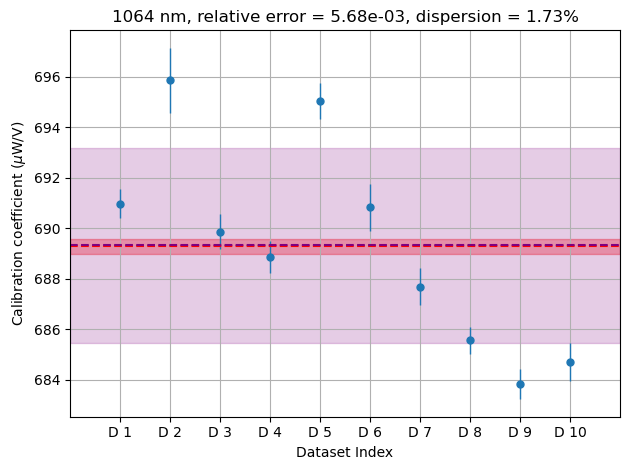

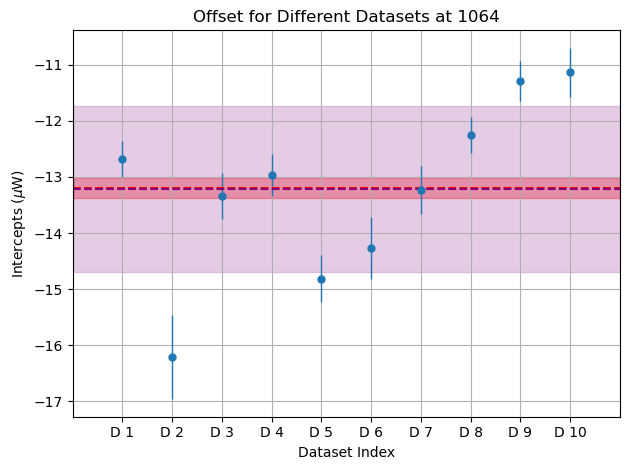

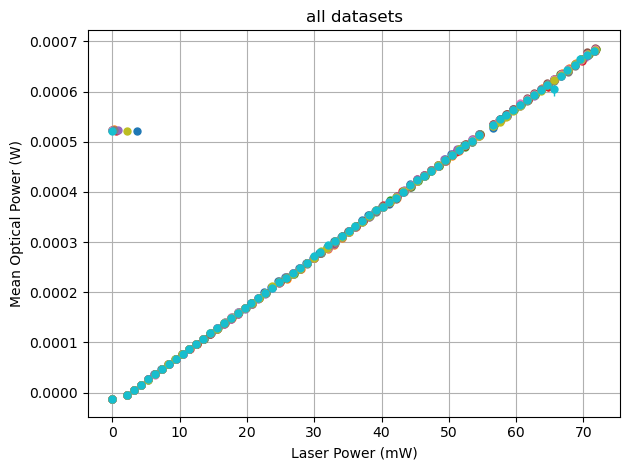

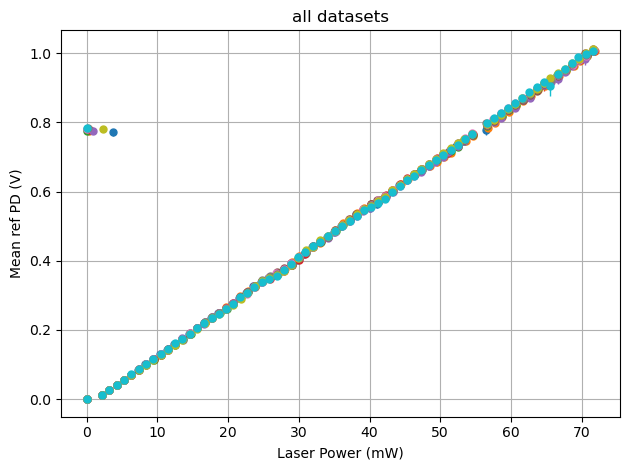

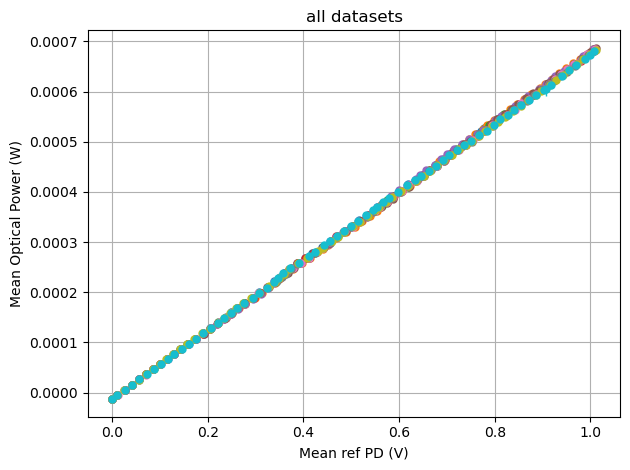

In [ ]:

#Obtain a deep look of the data
#Tfull, Tpedestal = Sensor_setup1('./Useful_data/setup1/Calibration_july_2024/data/1064nm','calibration_24072024_PD','1064')
#Tfull, Tpedestal = Sensor_setup1('./Useful_data/setup1/Calibration_july_2024/data/532nm','calibration_24072024_PD','532')
#temp_stable('./Useful_data/setup1/Calibration_july_2024/data/1064nm','1064')
#Tfull, Tpedestal = Sensor_setup1('./Useful_data/setup1/Temperatura_22_2024/data/532nm','temperatura_22_26072024_PD','532')
#Tfull, Tpedestal = Sensor_setup1('./Useful_data/setup1/Temperatura_22_2024/data/1064nm','temperatura_22_26072024_PD','1064')
#Tfull, Tpedestal = Sensor_setup1('./Useful_data/setup1/Temperatura_24_2024/data/532nm','temperatura_24_30072024_PD','532')
Tfull, Tpedestal = Sensor_setup1('./Data/setup1/2024_24_Temperatura/data/1064nm','temperatura_24_30072024_PD','1064')


Number of files in the folder with 532 in their name: 10
calibration_28082024
Directory './Plots/setup1/calibration_28082024/532nm' created.
Calibration coefficient found as linear adjustment of all the dataset = 641.8498353273329 +/- 0.3229247463653611 in $\mu$W/V
Calibration coefficient found as mean of the linear adjustment of each dataset = 641.687017059671 +/- 1.2908578505555528 in $\mu$W/V
relativeError =  -0.025373470762702504 % and dispersion =  0.7312389207925216 %
mean intercepts -3.194914029513898 error 0.2459527230563174
The pedestal of the values Optical Power (W)  are: Mean= 2.8178000000000004e-06  std= 2.1910000000000002e-07
The pedestal of the values ref PD (V)  are: Mean= -4.000000000000001e-06  std= 0.0


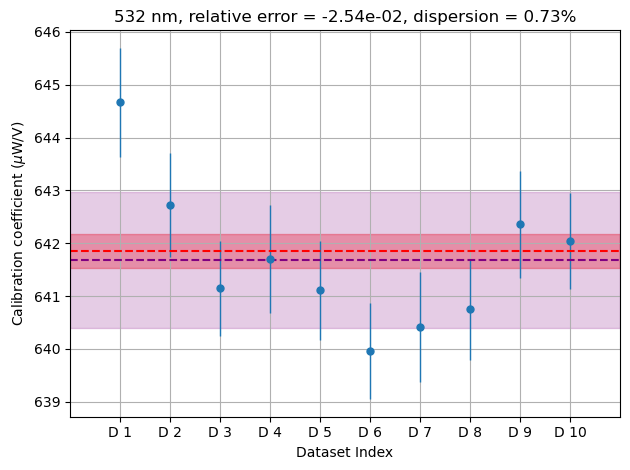

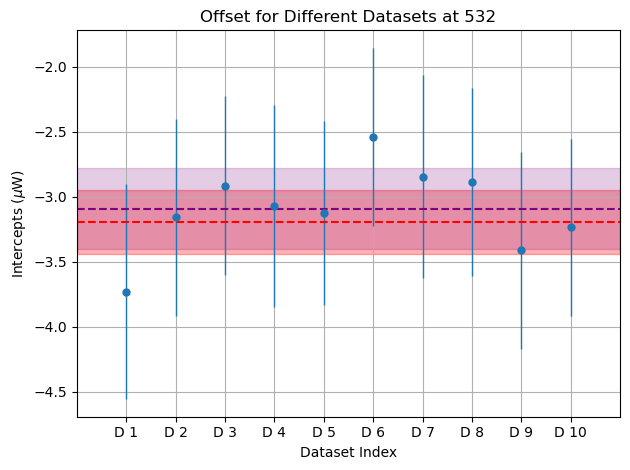

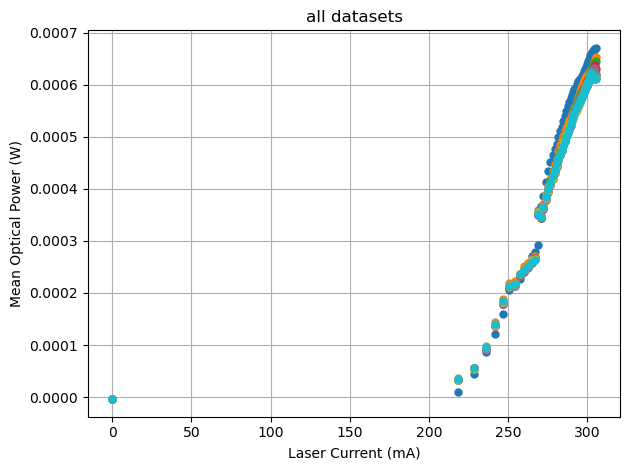

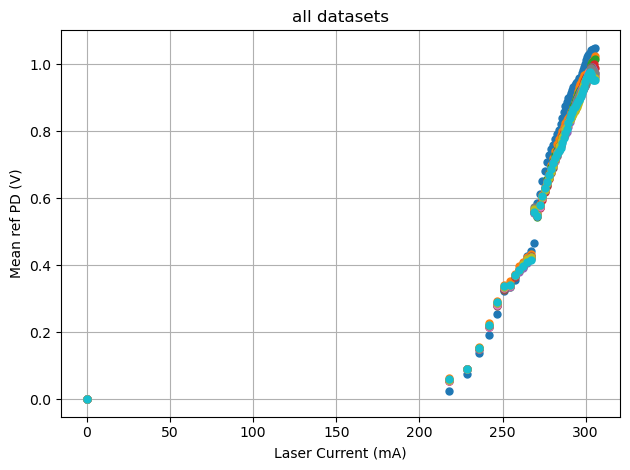

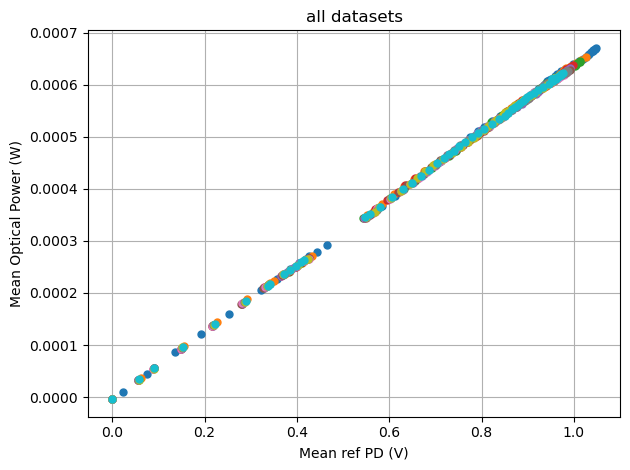

In [21]:
Tfull, Tpedestal = Sensor_setup1('./Data/setup1/calibration_29082024/calibration_28082024/532/','calibration_28082024_PD','532')